## Import Relevant Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install weights and biases
!pip install wandb

In [ ]:
# API key of wandb project
!wandb login 50ec2df756bf2e8a273dc36f5a363b8e445c743f

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Attention, ReLU, Add, Input, Multiply, Layer, Conv2D, BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop, SGD
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
import os
import pickle
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import SparseCategoricalAccuracy

from keras.models import Sequential
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import wandb


In [ ]:
name = "se_res_shallow_v1"

In [ ]:
# # This cell is executed only at the beginning of the project since the model is not created yet
# # Create a new run for model training with a given name
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="deep learning challenge",
#     name = name,
# )

# # get wandb id
# wandb.run.id

In [ ]:
# To change according to the model
name = "se_res_shallow_v1"
run_id = "8pdl0zvz"
wandb.init(
    # set the wandb project where this run will be logged
    project="deep learning challenge",
    id = run_id,
    resume = "must"
)


wandb: Currently logged in as: b_mokhtari (billal-mokhtari). Use `wandb login --relogin` to force relogin


## Define Class Models

In [ ]:
@keras.saving.register_keras_serializable()
class SEBlock(Layer):
  """
    Squeeze-and-Excitation (SE) Block layer.

    Args:
        channels (int): Number of input channels.
        ratio (int): Reduction ratio for the intermediate channels.

    Returns:
        Output tensor after applying the SE block.
  """
  def __init__(self, channels, ratio= 16):
     super(SEBlock, self).__init__()

     self.pooling =  GlobalAveragePooling2D()
     self.fc1 = Dense(channels // ratio, activation='relu')
     self.fc2 = Dense(channels, activation='sigmoid')

     def call(sekf, inputs):
      output = self.pooling(inputs)
      output = self.fc1
      output = self.fc2
      return output

@keras.saving.register_keras_serializable()
class SEResBlock(Layer):
    """
    Forward pass of the SE Block layer.

    Args:
        inputs: Input tensor.

    Returns:
        Output tensor after applying the SE block.
    """
    def __init__(self, filters):
        super(SEResBlock, self).__init__()

        # First convolution block in residual
        self.conv1 = Conv2D(filters, (3, 3), padding='same', strides=1)
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()

        # Second convolution block in residual
        self.conv2 = Conv2D(filters, (3, 3), padding='same', strides=1)
        self.bn2 = BatchNormalization()

        # SE Block
        self.se_block = SEBlock(filters)

        # Shortcut connection
        self.shortcut = Conv2D(filters, (1, 1), padding='same', strides=1)
        self.add = Add()
        self.relu2 = ReLU()

    def call(self, inputs):
        """
        Forward pass of the SERes Block layer.

        Args:
            inputs: Input tensor.

        Returns:
            Output tensor after applying the SERes block.
        """
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        # Apply SE Block
        se_output = self.se_block(x)
        x = Multiply()([x, se_output])

        shortcut = self.shortcut(inputs)
        x = self.add([x, shortcut])
        x = self.relu2(x)

        return x


@keras.saving.register_keras_serializable()
class SEResShallowV1(tf.keras.Model):
    """
    Shallow ResNet model with Squeeze-and-Excitation (SE) blocks.

    Args:
        num_classes (int): Number of output classes.
        filters (int): Number of filters in the initial convolutional layer.
        num_blocks (int): Number of residual blocks.

    Returns:
        Output tensor representing class probabilities.
    """
    def __init__(self, num_classes=5, filters=64, num_blocks=3):
        super(SEResShallowV1, self).__init__()

        # Initial convolution block
        self.conv1 = Conv2D(filters, (3, 3), padding='same', strides=1)
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()

        # Residual blocks
        self.res_blocks = [SEResBlock(filters*pow(2, i)) for i in range(num_blocks)]

        # Global average pooling and final dense layer
        self.global_avg_pooling = GlobalAveragePooling2D()
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        """
        Forward pass of the SEResShallowV1 model.

        Args:
            inputs: Input tensor.

        Returns:
            Output tensor representing class probabilities.
        """
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)
        for res_block in self.res_blocks:
            x = res_block(x)

        x = self.global_avg_pooling(x)
        x = self.fc(x)

        return x

## Import Data

In [ ]:
# Unzipping a file in Google Colab using the provided path to the zip file.
!unzip "/content/drive/MyDrive/ISIMA2/ISIMA/Deep learning/Challenge/Challenge/Data_Train_Valid.zip" -d "/content/data"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/data/images/rabbit/rabbit_124616.png  
  inflating: /content/data/__MACOSX/images/rabbit/._rabbit_124616.png  
  inflating: /content/data/images/rabbit/rabbit_076144.png  
  inflating: /content/data/__MACOSX/images/rabbit/._rabbit_076144.png  
  inflating: /content/data/images/rabbit/rabbit_061438.png  
  inflating: /content/data/__MACOSX/images/rabbit/._rabbit_061438.png  
  inflating: /content/data/images/rabbit/rabbit_009790.png  
  inflating: /content/data/__MACOSX/images/rabbit/._rabbit_009790.png  
  inflating: /content/data/images/rabbit/rabbit_041930.png  
  inflating: /content/data/__MACOSX/images/rabbit/._rabbit_041930.png  
  inflating: /content/data/images/rabbit/rabbit_067049.png  
  inflating: /content/data/__MACOSX/images/rabbit/._rabbit_067049.png  
  inflating: /content/data/images/rabbit/rabbit_036560.png  
  inflating: /content/data/__MACOSX/images/rabbit/._rabbit_0365

In [ ]:
def transform_data_structure(data_path, dataset_path):
    """
    Transform the structure of the dataset by organizing images into class directories.

    Args:
        data_path (str): Path to the directory containing the original dataset.
        dataset_path (str): Path to the directory where the transformed dataset will be created.

    Returns:
        None: The function organizes images into class directories in the specified dataset path.
    """
    # Create the dataset directory if it doesn't exist
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)

    # Load the CSV files
    train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
    valid_df = pd.read_csv(os.path.join(data_path, 'valid.csv'))

    # Create train and valid directories within the dataset directory
    train_dir = os.path.join(dataset_path, 'train')
    valid_dir = os.path.join(dataset_path, 'valid')

    # os.makedirs(train_dir)
    # os.makedirs(valid_dir)

    # Function to move images to the appropriate class directories
    def move_images(df, dest_path):
        for index, row in df.iterrows():
            image_name = row['image_name']
            class_label = row['class_label']
            class_name = None

            # Map class labels to class names
            if class_label == 0:
                class_name = 'basket'
            elif class_label == 1:
                class_name = 'eye'
            elif class_label == 2:
                class_name = 'binoculars'
            elif class_label == 3:
                class_name = 'rabbit'
            elif class_label == 4:
                class_name = 'hand'

            # Create the class directory if it doesn't exist
            class_dir = os.path.join(dest_path, class_name)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)

            # Move the image to the class directory
            shutil.copy(os.path.join(data_path, 'images', class_name, image_name), os.path.join(class_dir, image_name))

    # Move train images to the appropriate directories
    move_images(train_df, train_dir)

    # Move valid images to the appropriate directories
    move_images(valid_df, valid_dir)


transform_data_structure("/content/data", "/content/dataset")


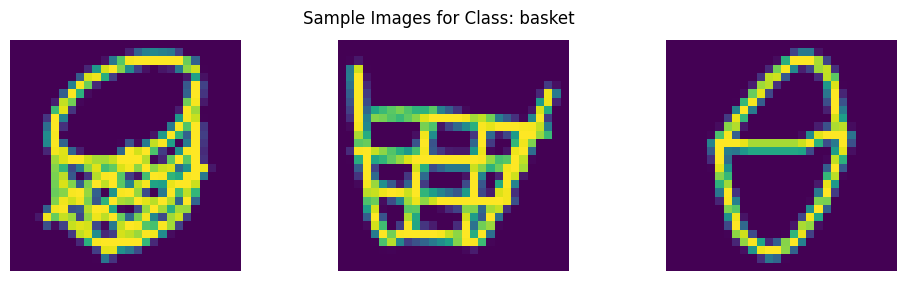

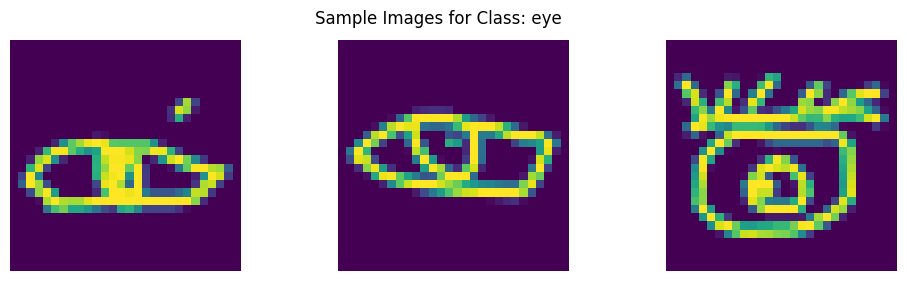

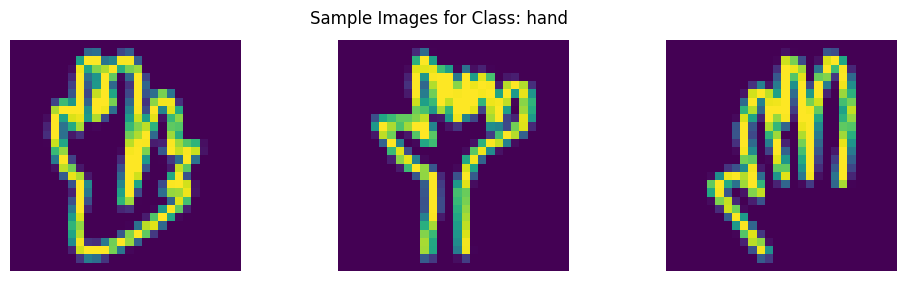

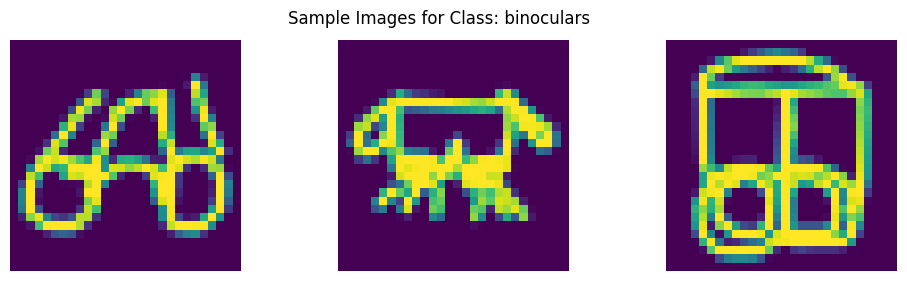

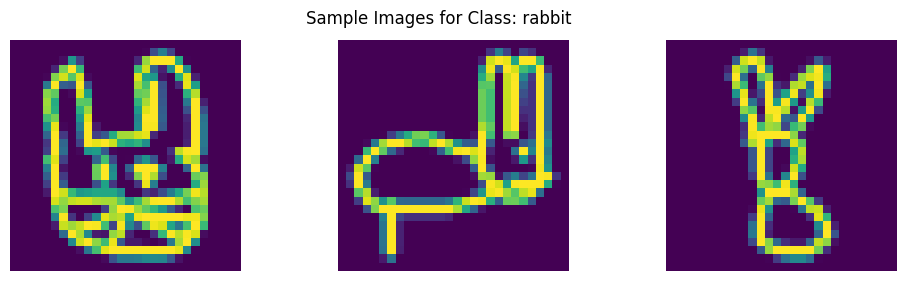

In [ ]:
def show_sample_images(dataset_path, num_samples_per_class=3):

      """
    Display sample images for each class in the dataset.

    Args:
        dataset_path (str): Path to the dataset directory containing class subdirectories.
        num_samples_per_class (int): Number of sample images to display for each class. Default is 3.

    Returns:
        None: Displays sample images for each class in the dataset.
    """
    # Get the class names
    class_names = os.listdir(dataset_path)

    # Display sample images for each class
    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_dir)

        # Randomly select a subset of images for display
        sample_images = random.sample(image_files, min(num_samples_per_class, len(image_files)))

        # Display the images
        plt.figure(figsize=(12, 3))
        plt.suptitle(f"Sample Images for Class: {class_name}")

        for i, image_name in enumerate(sample_images):
            img_path = os.path.join(class_dir, image_name)
            img = mpimg.imread(img_path)

            plt.subplot(1, num_samples_per_class, i + 1)
            plt.imshow(img)
            plt.axis('off')

        plt.show()

show_sample_images("/content/dataset/train")

Text(0.5, 1.0, 'Class: basket, Image: basket_001099.png\nShape: (28, 28)')

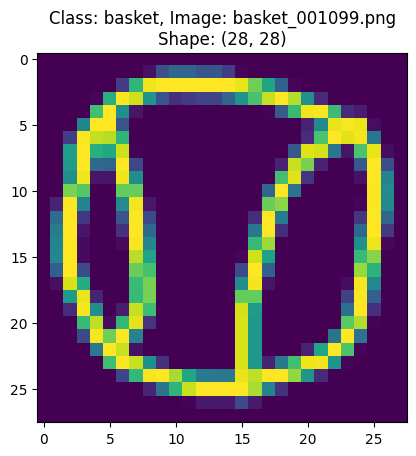

In [ ]:
def get_image_shape(image_path):
    """
    Get the shape (dimensions) of an image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        tuple: Tuple representing the shape (height, width, channels) of the image.
    """
    img = mpimg.imread(image_path)
    return img.shape

# Example usage
dataset_path = "/content/dataset/train"
class_name = "basket"  # Change this to the desired class
image_name = os.listdir(os.path.join(dataset_path, class_name))[0]

image_path = os.path.join(dataset_path, class_name, image_name)
image_shape = get_image_shape(image_path)

# Display the image and its shape
plt.imshow(mpimg.imread(image_path))
plt.title(f"Class: {class_name}, Image: {image_name}\nShape: {image_shape}")

## Save Model

In [ ]:
def create_directory_or_file(path, dir=True):
  """
    Create a directory or file at the specified path.

    Args:
        path (str): Path to the directory or file.
        is_dir (bool): If True, create a directory. If False, create a file.

    Returns:
        bool: True if the directory or file already exists, False if it was created.
  """
  if dir :
    if not os.path.exists(path) or not os.path.isdir(path):
      os.makedirs(path)
      return False

    return True

  else :
    # Check if the file exists
    if not os.path.exists(path):
      # Create the file if it doesn't exist
      with open(path, 'w') as file:
        pass
      print(f"The file '{path}' has been created.")

      return False

    return True


def save_checkpoint(path, history):
  """ The output directory structure
  output :
    - model_directory
      1. checkpoints
        * model_checkpoint_epoch{number}
        ...
      2. history.pkl
      3. configs.json

  """
  # create checkpoint path if it doesn't exist
  full_path = os.path.join(path, "checkpoints")
  create_directory_or_file(full_path)


  # save current evaluation metrics and loss in history.pkl (create it if it doesn't exist)
  history_path = os.path.join(path, "history.pkl")
  res = create_directory_or_file(history_path, dir = False)

  # if the file doesn't exist, we fill it with
  data = dict()
  if not res :
    index = 0
    data[index] = history

    with open(history_path, 'wb') as file:
      pickle.dump(data, file)

  else:
    try:
      # Open the file for reading in binary mode
      with open(history_path, 'rb+') as file:
        # Load the pickled data from the file
        loaded_data = pickle.load(file)

        # Add the new data inside
        index = max(loaded_data.keys())+1
        loaded_data[index] = history

      with open(history_path, 'wb') as file:
        # Save the new content in the file
        pickle.dump(loaded_data, file)

    except FileNotFoundError:
        print(f"The file '{history_path}' does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")




## Define Custom Callback

In [ ]:
class SaveCallback(Callback):
    """
    Callback to save model checkpoints and logs at the end of each epoch.

    Args:
        save_path (str): Path to the directory where checkpoints and logs will be saved.
    """
    def __init__(self, save_path):
        super(SaveCallback, self).__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Access the current loss and accuracy
        save_checkpoint(path = self.save_path, history=logs)
        wandb.log(logs)


## Model Training

In [ ]:
# Define model configurations
optimizer_configs = {"adam" : {
                        "learning_rate": 0.0005,
                        "beta_1": 0.9,
                        "beta_2": 0.999,
                        "epsilon": 1e-07
                      },

                     "rms_prop": {
                         "learning_rate": 0.001,
                         "rho": 0.9,
                         "momentum": 0.0,
                         "epsilon": 1e-07
                     },

                     "sgd": {
                         "learning_rate": 0.01,
                         "momentum": 0.0
                     }
                  }

loss_configs = {"sparse_categorical_crossentropy":{
               "from_logits": False}}


# Define compiling configurations
model_configs = {"optimizers": optimizer_configs,
           "losses": loss_configs}

In [ ]:
# monitor tells us according to which metric we save the best model during the training
monitor = "val_sparse_categorical_accuracy"

# Path to your pickle file
pickle_file_path = '/content/drive/MyDrive/ISIMA2/ISIMA/Deep Learning/Challenge/Challenge/output/checkpoints/'+name+'/history.pkl'

# Open the file for reading in binary mode
max_metric_monitor = None

# Check if the filepath exists
if os.path.exists(pickle_file_path):
  with open(pickle_file_path, 'rb') as file:
      # Load the pickled data from the file
      loaded_data = pickle.load(file)

  # Now, `loaded_data` contains the content of the pickle file
  max_metric_monitor = max([list(loaded_data.values())[i][monitor] for i in range(len(list(loaded_data.values())))])

In [ ]:
# Define training configurations
paths_config = {
    "model_checkpoint_path": "/content/drive/MyDrive/ISIMA2/ISIMA/Deep learning/Challenge/Challenge/output/checkpoints/"+name,
    "model_name": name,
}

model_checkpoint_configs = {
    "filepath":os.path.join(paths_config["model_checkpoint_path"],
                            "checkpoints", "{}.model.keras".format(paths_config["model_name"])),
    "monitor": monitor,
    "verbose": 0,
    "save_best_only": True,
    "save_weights_only": False,
    "mode": "max",
    "save_freq": "epoch",
    "initial_value_threshold": max_metric_monitor,
}


training_configs = {
    "batch_size": 256,
    "target_size": (28, 28),
    "num_epochs": 15
}


In [ ]:
# Create an instance of the SEResShallowV1 model with specified configurations
model = SEResShallowV1(filters = 32, num_blocks=2)

# Compile the model with optimizer, loss, and metrics configurations
model.compile(optimizer=Adam(**model_configs["optimizers"]["adam"]),
              loss = SparseCategoricalCrossentropy(**model_configs["losses"]["sparse_categorical_crossentropy"]),
              metrics=[SparseCategoricalAccuracy()])

# Create an instance of the SaveCallback class
save_callback = SaveCallback(paths_config["model_checkpoint_path"])

# Create a ModelCheckpoint callback for saving the best model during training
model_checkpoint = ModelCheckpoint(**model_checkpoint_configs)

In [ ]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = training_configs["batch_size"]

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',
    target_size=training_configs["target_size"],
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='grayscale'
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/dataset/valid',
    target_size=training_configs["target_size"],
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='grayscale'
)

Found 75000 images belonging to 5 classes.
Found 25000 images belonging to 5 classes.


In [ ]:
def train(path, model):
    """
    Train the specified model using the provided data generators.

    Args:
        path (str): Path to the model weights file for loading.
        model: Instance of the Keras model to be trained.

    Returns:
        None: Trains the model and logs the training history.
    """
    # Check if the model weights file exists and load the weights if available

    if os.path.exists(path):
      print("The model is successfully loaded")
      model.load_weights(path, by_name=True)

    history = model.fit(
              train_generator,
              epochs=training_configs["num_epochs"],
              steps_per_epoch=train_generator.samples // batch_size,
              validation_data=valid_generator,
              validation_steps=valid_generator.samples // batch_size,
              callbacks=[save_callback, model_checkpoint]
              )


In [ ]:
train(model_checkpoint_configs["filepath"], model)

The model is successfully loaded
Epoch 1/15
292/292 [==============================] - 95s 325ms/step - loss: 0.0969 - sparse_categorical_accuracy: 0.9681 - val_loss: 0.1564 - val_sparse_categorical_accuracy: 0.9533
Epoch 2/15
292/292 [==============================] - 90s 308ms/step - loss: 0.0968 - sparse_categorical_accuracy: 0.9678 - val_loss: 0.1617 - val_sparse_categorical_accuracy: 0.9559
Epoch 3/15
292/292 [==============================] - 91s 313ms/step - loss: 0.0954 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.1816 - val_sparse_categorical_accuracy: 0.9505
Epoch 4/15
292/292 [==============================] - 89s 306ms/step - loss: 0.0973 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.1810 - val_sparse_categorical_accuracy: 0.9484
Epoch 5/15
292/292 [==============================] - 81s 277ms/step - loss: 0.0969 - sparse_categorical_accuracy: 0.9673 - val_loss: 0.1594 - val_sparse_categorical_accuracy: 0.9552
Epoch 6/15
292/292 [==============================] 

In [ ]:
model.save("/content/drive/MyDrive/ISIMA2/ISIMA/Deep learning/Challenge/Challenge/output/last/model.keras")


### Select the best model


In [ ]:

# Directory where the history files are stored
history_dir = '/content/drive/MyDrive/ISIMA/Deep learning/Challenge/Challenge/output/checkpoints'


monitor = "val_sparse_categorical_accuracy"

# List of model names
model_names = [
    "attention_v1",
    "res_shallow_v2_rms_prop",
    "se_res_shallow_v1",
    "res_shallow_v2",
    "res_shallow_v1"
]

# Load and evaluate each model based on the last epoch in the history file
results = []
for model_name in model_names:
    # Load the training history from the .pkl file
    with open(os.path.join(history_dir, model_name,'history.pkl'), 'rb') as file:
        history = pickle.load(file)
        max_metric_monitor = max([list(history.values())[i][monitor] for i in range(len(list(history.values())))])
        argmax = tf.argmax([list(history.values())[i][monitor] for i in range(len(list(history.values())))])
        print(argmax)
        list_result = [list(history.values())[i] for i in range(len(list(history.values())))][argmax]
        result={
            'model_name': model_name,
            'result_list': list_result
        }
        results.append(result)
results

In [ ]:


# Extract data for plotting
model_names = [result['model_name'] for result in results]
train_accuracies = [result['result_list']['sparse_categorical_accuracy'] for result in results]
val_accuracies = [result['result_list']['val_sparse_categorical_accuracy'] for result in results]
train_losses = [result['result_list']['loss'] for result in results]
val_losses = [result['result_list']['val_loss'] for result in results]

# Plot training and validation accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Training Accuracy', color=color)
ax1.bar(model_names, train_accuracies, color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.plot(model_names, val_accuracies, color=color, marker='o', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training and Validation Accuracy for Each Model')
plt.show()

# Plot training and validation loss
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Training Loss', color=color)
ax1.bar(model_names, train_losses, color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation Loss', color=color)
ax2.plot(model_names, val_losses, color=color, marker='o', label='Validation Loss')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training and Validation Loss for Each Model')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
# # Path to the directory containing the images you want to predict
images_dir = '/content/drive/MyDrive/ISIMA2/ISIMA/Deep learning/Challenge/Challenge/test_data'

# # List to store image paths
image_paths = []

# Iterate over the files in the directory
for root, dirs, files in os.walk(images_dir):
    for file in files:
        # Append the full path of each image file to the list
        image_paths.append(os.path.join(root, file))

# Iterate over the image paths and make predictions
for image_path in image_paths:
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(28, 28), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to be between 0 and 1

    # Make predictions
    predictions = model2.predict(img_array)

    # Get the class label with the highest probability
    predicted_class = np.argmax(predictions[0])

    # Print the result
    print(f"Image: {image_path}, Predicted Class: {predicted_class}")

1/1 [==============================] - 0s 451ms/step
Image: /content/drive/MyDrive/ISIMA2/ISIMA/Deep learning/Challenge/Challenge/test_data/basket_000004.png, Predicted Class: 0
1/1 [==============================] - 0s 21ms/step
Image: /content/drive/MyDrive/ISIMA2/ISIMA/Deep learning/Challenge/Challenge/test_data/rabbit_001550.png, Predicted Class: 4
1/1 [==============================] - 0s 18ms/step
Image: /content/drive/MyDrive/ISIMA2/ISIMA/Deep learning/Challenge/Challenge/test_data/eye_002634.png, Predicted Class: 2
1/1 [==============================] - 0s 18ms/step
Image: /content/drive/MyDrive/ISIMA2/ISIMA/Deep learning/Challenge/Challenge/test_data/hand_000273.png, Predicted Class: 3
1/1 [==============================] - 0s 19ms/step
Image: /content/drive/MyDrive/ISIMA2/ISIMA/Deep learning/Challenge/Challenge/test_data/hand_000997.png, Predicted Class: 0
1/1 [==============================] - 0s 18ms/step
Image: /content/drive/MyDrive/ISIMA2/ISIMA/Deep learning/Challenge/Ch

## Experiments and Results
We trained six models with different architectures. To track the performances along the training process, we have used [**Weights & Biases**](https://wandb.ai/site) which is a platform that helps AI developers to organize their ML workflow from end-to-end. We have used **Sparse Categorical Crossentropy** as loss function which is given by :
$$Loss = -\sum_{i=1}^{\# classes} y_i \cdot \log(p_i)$$

For evaluation, we employed the **Sparse Categorical Accuracy** metric. The models have been trained until they became stable in their convergence. The [performances](https://api.wandb.ai/links/billal-mokhtari/junwjsh9) along the training process are shown in the following figure.

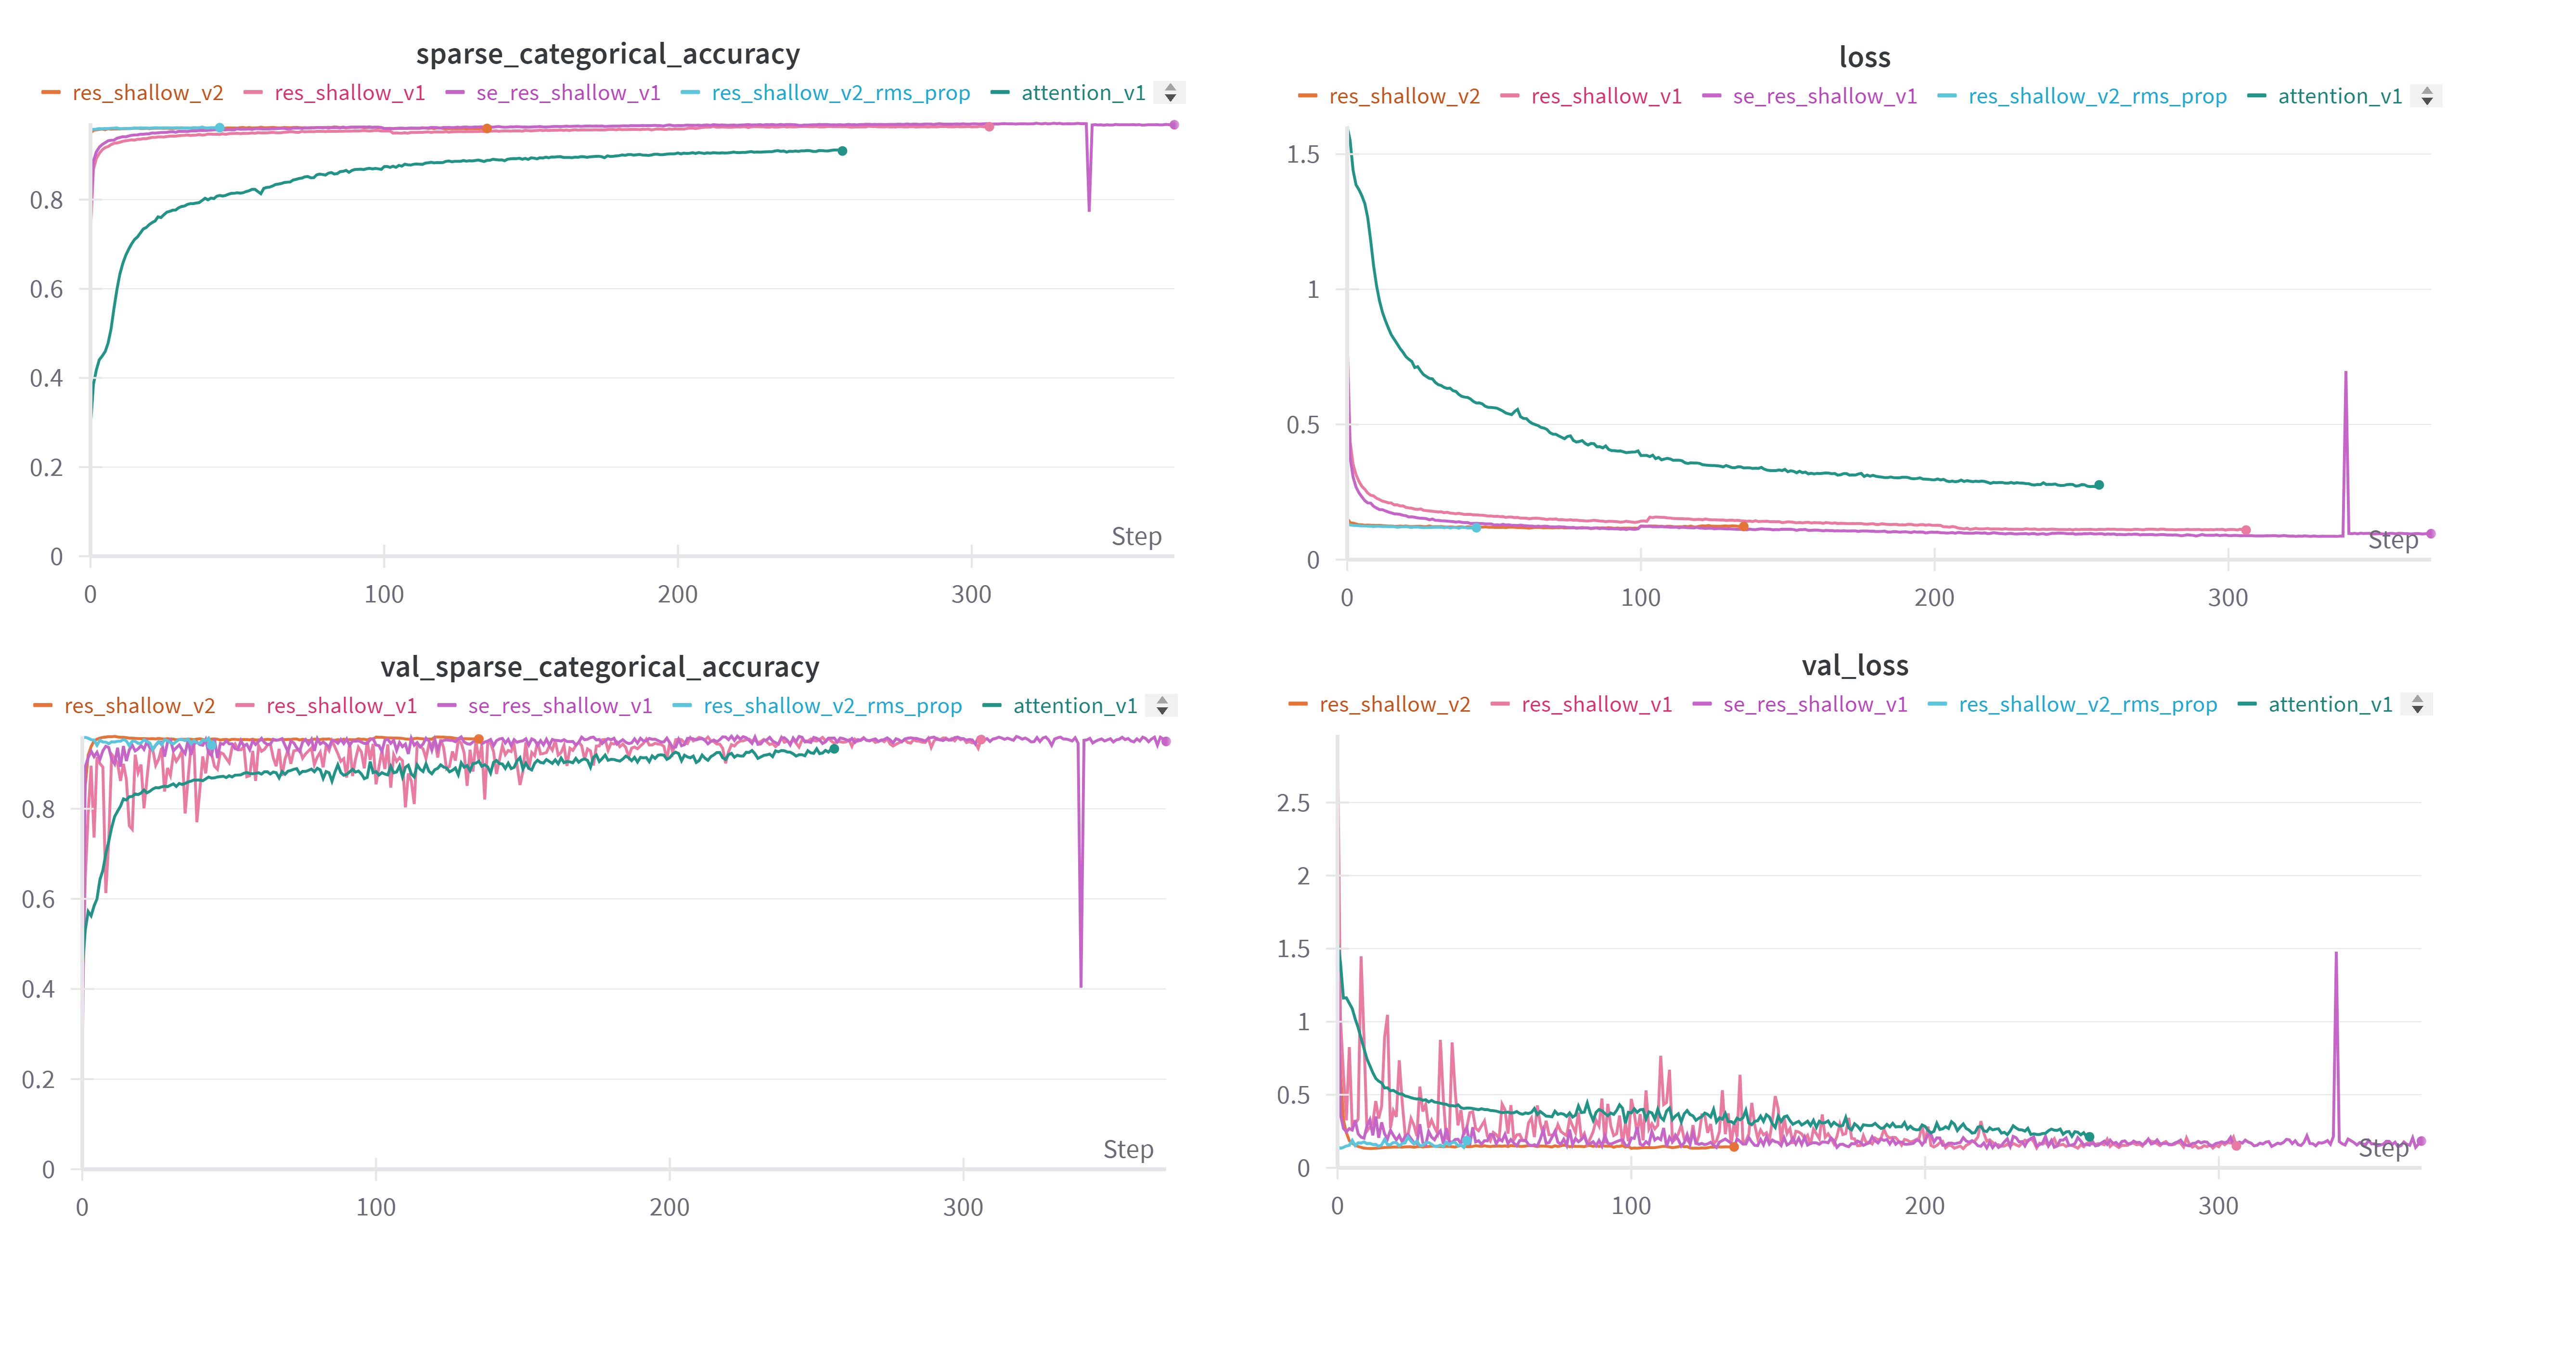

The models are approximately converging with the same way. We can easily notice that AttentionV1 is not learning properly since its validation accuracy is higher than its training accuracy. Hence, in order to select the best model, we have taken the best models from each model and compare them. The results of comparaison are shown below.
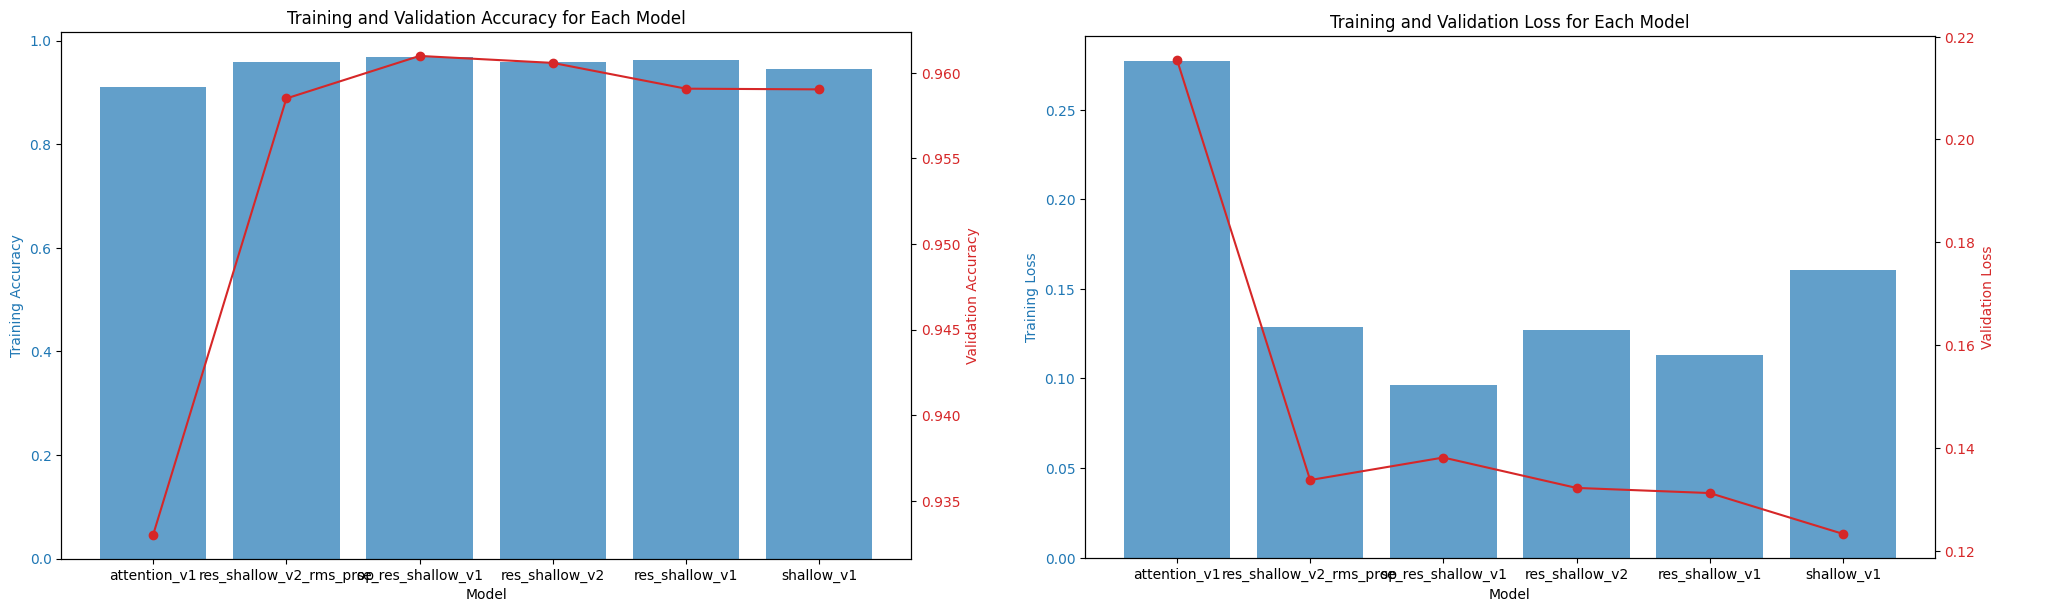

It is observed that the **Squeeze and Excitation** model exhibits higher training and validation accuracy with lower loss, demonstrating robust performance without overfitting.

**The Squeeze and Excitation (SE) architecture**, introduced by [Hu et al. in "Squeeze-and-Excitation Networks" (2018)](https://arxiv.org/pdf/1709.01507.pdf), is a neural network design aimed at refining feature representations through channel-wise feature recalibration. The SE block involves two crucial steps: squeeze and excitation. During squeezing, global spatial information is captured via global average pooling, resulting in a channel descriptor. The excitation step employs a small fully connected network to generate channel-wise scaling factors. These factors are then applied to the original feature map, dynamically adjusting the importance of individual channels. This adaptive recalibration enhances the model's discriminative power, contributing to improved accuracy in image classification and other computer vision tasks. The SE architecture has become a valuable component widely incorporated into various deep learning models to optimize feature extraction and enhance overall performance.

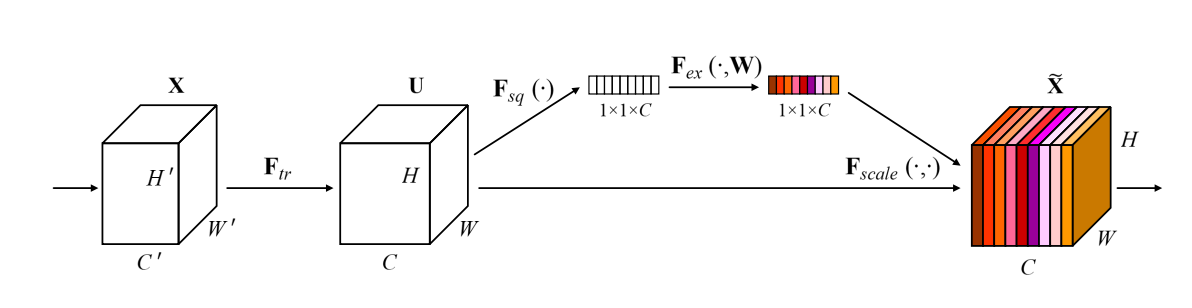




## References


<div itemscope itemtype="http://schema.org/ScholarlyArticle">
  <span itemprop="author" itemscope itemtype="http://schema.org/Person">
    <span itemprop="name">Jie Hu</span>,
  </span>
  <span itemprop="author" itemscope itemtype="http://schema.org/Person">
    <span itemprop="name">Li Shen</span>,
  </span>
  <span itemprop="author" itemscope itemtype="http://schema.org/Person">
    <span itemprop="name">Gang Sun</span>
  </span><br>
  <span itemprop="headline">Squeeze-and-Excitation Networks</span><br>
  <span itemprop="citation" itemscope itemtype="http://schema.org/CreativeWork">
    <span itemprop="isPartOf" itemscope itemtype="http://schema.org/Periodical">
      <span itemprop="name">Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition</span>,
    </span>
    <span itemprop="pageStart">7132</span>,
    <span itemprop="pageEnd">7141</span>,
    <span itemprop="datePublished">2018</span>,
    <span itemprop="url" content="https://arxiv.org/pdf/1709.01507.pdf">
      <a href="https://arxiv.org/pdf/1709.01507.pdf" target="_blank">[PDF]</a>
    </span>
  </span>
</div>






